<center>
<img src='Deerns-logo.jpg' height="100">
<center/>

# COP Calculator



In [1]:
import inputs
import refdata as ref
import isentropic_efficiency as isen
import scopcalc
import numpy
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt

### Log p-h diagram

The thermodynamic properties of refrigerants used in heat pumps can be visualised in a log p-h diagram. The pressure is plotted on a logarithmic scale against the enthalpy (energy content) of the refrigerant. Log p-h diagrams are used in refrigeration technology to determine thermodynamic properties in a refrigeration cycle to evaluate its performance.\
\
 The log p-h diagram consists of a couple of important features:
- The quasi bell-shaped curve (saturation curve) in the middle of the graph indicates where the refrigerant is in a saturated state: either saturated liquid (bubble point) or saturated gas (dew point). 
- On the left side of the saturation curve, the refrigerant is in liquid phase, subcooled below its saturation temperature. 
- On the right side of the saturation curve the refrigerant is in gasseous state, superheated above its saturation temperature. 
- The area underneath the saturation curve indicates a two-phase zone, where both liquid and gasseous phases exist. Accordingly, this is the region where evaporation and condensation of the refrigerant takes place. The temperature in this region stays constant at constant pressure while the energy content rises due to the absorbing of latent heat. \

In [2]:
# Plotting saturation curve
fig, ax = plt.subplots()

toplot_h_liq = ref.enthalpy_liquid_saturated
toplot_h_gas = ref.enthalpy_gas_saturated

toplot_p_gas = ref.pressure_saturated_gas
toplot_p_liq = ref.pressure_saturated_liq

ax.plot(toplot_h_liq, toplot_p_liq, color='k')
ax.plot(toplot_h_gas, toplot_p_gas, color='k')

plt.yscale('log')
plt.xlabel("Enthalpy (kJ/kg)")
plt.ylabel("Pressure (bar)")
plt.title("Log p-h diagram for refrigerant " + inputs.refrigerant)
plt.grid()
plt.ylim(1, max(toplot_p_gas + 10))
plt.close(fig)

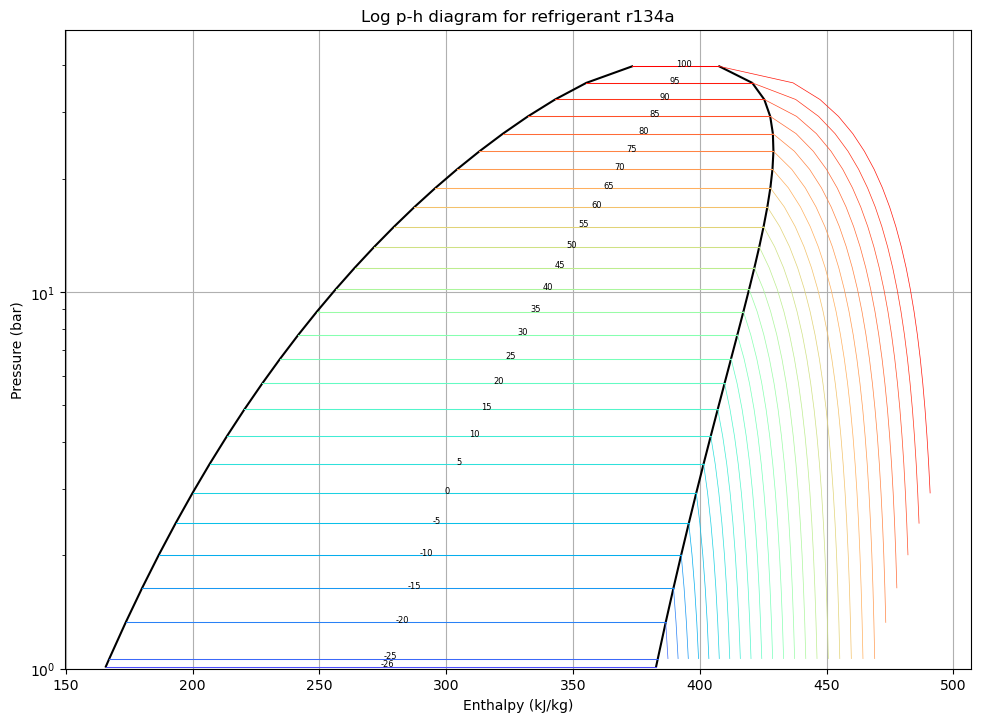

In [3]:
# Plotting temperature lines
# Two phase region
toploth_sat_templine_l = ref.saturated_refrigerant_data['Enthalpy_liq']
toploth_sat_templine_g = ref.enthalpy_gas_saturated_func(toplot_p_gas)
toplot_label = ref.saturated_refrigerant_data['Temp_liq']
color = iter(plt.cm.rainbow(numpy.linspace(0.1, 1, len(toplot_p_gas))))

for xl, xg, yl, yg, label in zip(toploth_sat_templine_l, toploth_sat_templine_g, toplot_p_liq, toplot_p_gas, toplot_label):
    setcolor = next(color)
    ax.plot([xl,xg],[yl,yg], c = setcolor, linewidth = 0.75)

    label_x = xl + ((xg-xl) / 2)
    label_y = yl + ((yg-yl) / 2)
    ax.annotate(str(round(label)),xy=(label_x, label_y), size = 6)
    
# Superheated region
mydata = ref.superheated_refrigerant_data

for myvalue in mydata.Temperature: 
    if not float(myvalue).is_integer() or myvalue > max(toplot_label):
        mydata =  mydata.drop(mydata.index[mydata.Temperature == myvalue])
        
grouped = mydata.groupby(by=['Temperature'])
reference = mydata.Temperature.drop_duplicates()
color2 = iter(plt.cm.rainbow(numpy.linspace(0.1, 1, len(toplot_p_gas))))

for plottemp in reference:
    df_toplot = grouped.get_group(plottemp)
    c2 = next(color2)
    ax.plot(df_toplot.Enthalpy, df_toplot.Pressure, c = c2, linewidth = 0.5)

fig.set_size_inches(11.7,8.3)
fig

### Evaporator temperature
The temperature of the refrigerant in the evaporator (cold side) in $\degree C $ .\
Default values from EN-15316 are used to 'model' the heat transfer between source and evaporator as a temperature difference.

<center>

|Source|$\Delta T_e \:(K) $|
|-|-|
|Air|6|
|Water|6|

</center>

Note that the temperature difference stays the same regardless of the source type


In [4]:
if inputs.source_type == 'Air':
    evaporator_temp = inputs.source_temp - 6
elif inputs.source_type == 'Water':
    evaporator_temp = inputs.source_temp - 6
elif inputs.source_type == 'Advanced':
    evaporator_temp = inputs.source_temp - inputs.delta_T_source_evaporator

### Condensor temperature
The temperature of the refrigerant in the condensor (hot side) in $\degree C $ \
Default values from EN-15316 are used to 'model' the heat transfer between sink and condensor as a temperature difference, dependant on the type of source.

<center>

|Sink|$\Delta T_c \:(K) $|
|-|-|
|Air|12|
|Water|5|

</center>

In case the sink type 'Water' is selected, the user is prompted to enter the water return temperature. in this case, the condensor temperature is calculated according to:

\begin{equation}
T_c = -\frac{T_r - T_s\cdot\exp(\frac{T_r - T_s}{\Delta T_{log}})}{\exp(\frac{T_s - T_r}{\Delta T_{log}}) - 1}
\end{equation}

With $ T_r $ and $ T_s $ being return and supply temperature, respectively, and  $ \Delta T_{log} $ being the logaritmic mean temperature difference between the heating water and the refrigerant in the condensor. (source: Maivel, M. & Kurnitski, J. (2015). https://doi.org/10.1016/j.enbuild.2015.02.048)

In [5]:
if inputs.sink_type == 'Air':
    condensor_temp = inputs.sink_temp + 12

elif inputs.sink_type == 'Water':
    delta_T_sink_condensor = 5
    supply_temp = inputs.sink_temp
    return_temp = inputs.sink_temp_return

    condensor_temp = (-(return_temp-supply_temp*numpy.exp((supply_temp
                      - return_temp)/delta_T_sink_condensor)) / (numpy.exp(
                      (supply_temp-return_temp) / delta_T_sink_condensor)-1)) \
                       + delta_T_sink_condensor

elif inputs.sinkType == 'Advanced':
    condensor_temp = inputs.sink_temp + inputs.delta_T_sink_condensor

### 1. Compressor intake

Although the refrigerant theoretically should be in the saturated gas stage, in practical situations it is superheated above the saturation temperature to avoid liquid refrigerant entering the compressor. Thus the thermodynamic properties at the compressor intake are calculated based on the calculated evaporator temperature and the amount of superheat in the suction line. \
\
The values for enthalpy (h) and entropy (s) are calculated as a function of the amount of superheat and pressure at the intake.


In [6]:
p1 = ref.pressure_saturated_liq_func(evaporator_temp)[()]
t1 = evaporator_temp + inputs.delta_T_superheat_suction
h1 = ref.enthalpy_superheated_func(inputs.delta_T_superheat_suction, p1)[0]
s1 = interpolate.bisplev(inputs.delta_T_superheat_suction, p1, ref.entropy_superheated_func)

Vapor quality (x) is only apllicable if the refrigerant is evaporating or condensing ( 0 < x < 1 ), or when the refrigerant is in either saturated liquid stage (x = 0) or saturated gasseous state (x = 1).

In [7]:
if inputs.delta_T_superheat_suction == 0:
    x1 = 1
else:
    x1 = '-'

### 2s. Compressor output (isentropic)
The thermodynamic properties are calculated, based on the isentropic nature of an ideal compression cycle, thus assuming equal entropy in compressor intake and outlet.

In [8]:
# Compressor output (isentropic)
p2s = ref.pressure_saturated_gas_func(condensor_temp)
s2s = s1
dt2s = interpolate.bisplev(s2s, p2s, ref.dt_s_superheated_func)
t2s = condensor_temp + dt2s
x2s = '-'
h2s = ref.enthalpy_superheated_func(dt2s, p2s)[0]

To estimate the isentropic efficiency, the pressure ratio is calculated. Together with the ideal pressure ratio (default: 3) and the type of compressor, the isentropic efficiency is estimated (source*: J. Campbell, (2011). https://bit.ly/2VhjlOv)

In [9]:
pressureratio = p2s/p1
ideal = inputs.ideal_pressure_ratio
isentropic_efficiency = isen.getefficiency(pressureratio)

### 2. Compressor output (real)
The properties of point 2s are corrected for isentropic efficiency, defined as:



\begin{equation}
\eta_{is} = \frac{h_{2s}-h_1}{h_2-h_1}
\end{equation}



In [10]:
p2 = p2s
h2 = h1 + (h2s-h1) / isentropic_efficiency
dt2 = interpolate.bisplev(h2, p2, ref.dt_h_superheated_func)
t2 = condensor_temp + dt2
s2 = interpolate.bisplev(dt2, p2, ref.entropy_superheated_func)[()]
x2 = '-'

### 3. Expansion valve intake

First, the saturated gas properties are compared to the saturated liquid properties. In case of refrigerant mixtures (r4xxx etc.), temperature in saturated gaseous state will vary from the temperature of saturated liquid state at equal pressures, due to the zeotropic nature of these mixtures (temperature glide). \
Next, the remaining properties are calculated, assuming that the refrigerant is in saturated liquid state. Vapor quality x will therefore always be 0.

In [11]:
p3 = p2
t3 = ref.temp_liquid_saturated_func(p3)
h3 = ref.enthalpy_liquid_saturated_func(p3)
s3 = ref.entropy_liquid_saturated_func(p3)
x3 = 0

### 4. Expansion valve outlet
The properties of the refrigerant at the expansion valve outlet are calculated assuming isenthalp (equal enthalpy) behaviour of the expansion valve. Furthermore, temperature and pressure wil lreturn to the values of point 1 (evaporator).


In [12]:
p4 = p1
t4 = t1
h4 = h3

Calculation of vapor quality is neccesary in order to calculate the entropy value in point 4. Vapor quality at point $i$ is defined as:

\begin{equation}

x_i = \frac{h_i-h_l}{h_g-h_l}

\end{equation}

Where $h_l$ and $h_g$ are the enthalpy values of saturated liquid and saturated gas at equal pressure $p_i$, respectively.

In [13]:
hl = ref.enthalpy_liquid_saturated_func(p4)
hg = ref.enthalpy_gas_saturated_func(p1)
x4 = (h4-hl) / (hg-hl)

Equal to the defenition mentioned above, vapor quality at point $i$ is defined as:

\begin{equation}

x_i = \frac{s_i-s_l}{s_g-s_l}

\end{equation}

Consequently, entropy in point $i$ can be calculated:
\begin{equation}
s_i = s_l + x_i \cdot (s_g-s_l)
\end{equation}

Note that this value is solely of interest for completeness of the table of refrigerant properties.

In [14]:
sl = ref.entropy_liquid_saturated_func(p4)
sg = ref.entropy_gas_saturated_func(p1)
s4 = sl + x4 * (sg-sl)

### COP calculation
The *coefficient of performance* (COP) of a heat pump is caculated as the quotient of the useful energy (heat flow) delivered by the heat pump $\dot{Q}$ and the electrical power consumption of the compressor $E$:

\begin{equation}
COP = \frac{\dot{Q}}{E}
\end{equation}

$\dot{Q}$ and $E$ can be calculated from the thermodynamic properties calculated in the various points as mentioned above, specifically utilising the enthalpy values:

\begin{equation}

\dot{Q} = \dot{m}\cdot\Delta h_{condensor} 

\end{equation}

\begin{equation}

E = \dot{m}\cdot\Delta h_{compressor}

\end{equation}

With $\dot{m}$ being the mass flow of refrigerant in the cycle.\
Combining above equations gives:

\begin{equation}

COP = \frac{\Delta h_{condensor}}{\Delta h_{compressor}}

\end{equation}

or:

\begin{equation}

COP = \frac{\Delta h_3 - h_2}{\Delta h_2 -h_1}

\end{equation}

Furthermore, the efficiency of the (assumed electric) motor driving the heat pump compressor is considered, with a default value of $\eta_{motor} = 0.85 $, such that:

\begin{equation}

\Delta h_{compressor} = \frac{h_2-h1}{\eta_{motor}}

\end{equation}


In [15]:
delta_h_compressor = (h2-h1) / (inputs.motor_efficiency/100)
delta_h_condensor = h2-h3
cop = delta_h_condensor/delta_h_compressor

In [16]:
cop_carnot = (condensor_temp+273.15) / (condensor_temp-evaporator_temp)
carnot_efficiency = cop / cop_carnot

In [17]:
# Creating table
reftable = pd.DataFrame(
    [
        ['1',t1, p1, h1, s1, x1], 
        ['2s', t2s, p2s, h2s, s2s, x2s], 
        ['2', t2, p2, h2, s2, x2], 
        ['3', t3, p3, h3, s3, x3], 
        ['4', t4, p4, h4, s4, x4], 
    ]
)

reftable.columns = ['point', 'T (°C)', 'p (bar)', 'h (kJ/kg)', 
                's (kJ/kgK)', 'x']


reftable = reftable.set_index('point', append=False)

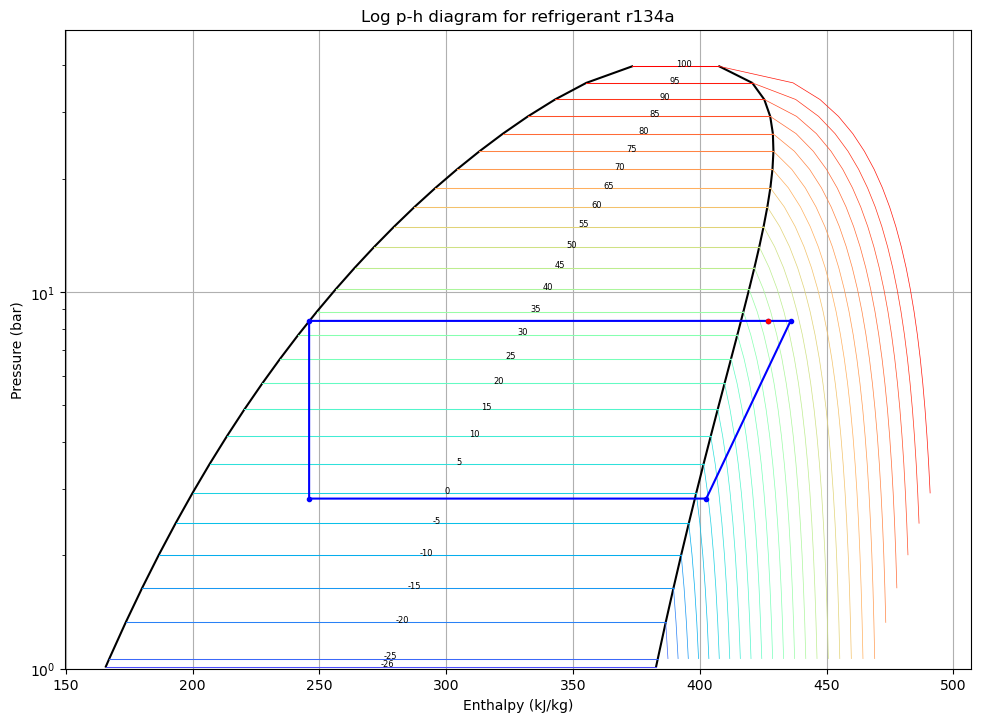

In [18]:
# Plot cycle

ax.plot(reftable['h (kJ/kg)'] , reftable['p (bar)'], '.b')
ax.plot([h1,h2,h3,h4,h1] , [p1,p2,p3,p4,p1], 'b')
ax.plot(h2s,p2s, '.r')
fig

In [19]:
# Flow rates etc

mass_flowrate_refrigerant = inputs.capacity/delta_h_condensor
RHO_C = 4000
volume_rate_water = inputs.capacity / ((inputs.sink_temp - inputs.sink_temp_return)*RHO_C)
electric_power = inputs.capacity/cop

In [20]:
[COPbin_toplot, scop] = scopcalc.getscop(cop)
plot_loadratio = numpy.linspace(1,0, len(COPbin_toplot))

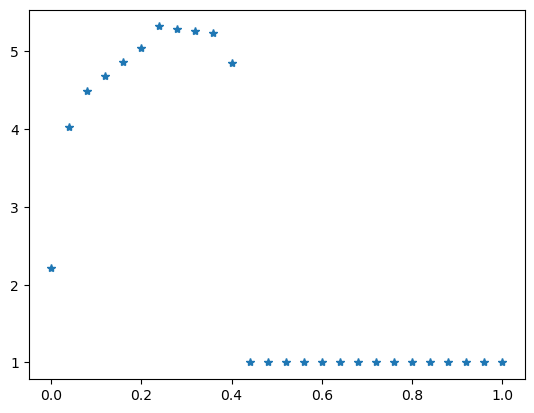

In [22]:
plt.plot(plot_loadratio, COPbin_toplot, '*')

In [ ]:
outputtable = pd.DataFrame(
    [
        ['COP',round(cop,2)],
        ['SCOP', scop],
        ['Carnot COP', round(cop_carnot,2)], 
        ['Carnot efficiency (%)', round(carnot_efficiency,3)*100], 
        ['Electric power (kW)', round(electric_power,1)], 
        ['Refrigerant mass flow rate (kg/s)', mass_flowrate_refrigerant],
        [ 'Water volume flow rate (kg/s)', volume_rate_water]
    ]   
)

In [ ]:
outputtable

,0,1
0,COP,4.850000
1,SCOP,4.591859
2,Carnot COP,9.030000
3,Carnot efficiency (%),53.800000
4,Electric power (kW),2.100000
5,Refrigerant mass flow rate (kg/s),0.052675
6,Water volume flow rate (kg/s),0.000500


In [ ]:
inputs.inputtable

,0,1
0,Sink,Water
1,Source,Air
2,Sink temperature (°C),25
3,Sink temperature (return) (°C),20
4,Source temperature (°C),5
5,Refrigerant,r134a
6,Capacity (kW),10


In [ ]:
reftable

,T (°C),p (bar),h (kJ/kg),s (kJ/kgK),x
point,,,,,
1,4,2.829,402.548032,1.747629,-
2s,42.923201,8.381748793623373,426.825189,1.747629,-
2,51.459751,8.381748793623373,435.805043,1.775324,-
3,32.90988353434663,8.381748793623373,245.96261019307738,1.1573854642579946,0
4,4,2.829,245.96261019307738,1.168821,0.237267
